# Beamforming (plane-wave, field data, pytorch)

In this notebook, we estimate arrival-of-angle of the primary microseism (and some earthquakes) as seen from the Gräfenberg array. The Gräfenberg is part of the [German Regional Seismic Network](https://www.fdsn.org/networks/detail/GR/) (all stations starting with GR).

This notebook demonstrates the following aspects missing from the other notebooks:
- Plane-wave beamforming, sampling slowness space instead of source coordinates.
- How to incorporate seismic field data downloaded directly via FDSN using obspy.
- How to beamform in multiple (overlapping) time windows in the same efficient matrix formulation. This is achieved by a) preparing `data_spectra_all` with an additional dimension (the time windows) and b) incoporating this dimensions (labelled `t`) in the computation of the cross-spectral density matrix `K` and the beampowers (now called `beampowers_over_time`).

## Additional requirements

[obspy](https://docs.obspy.org) to download and pre-process seismograms and station metadata.

## 1. Data and geometry

In [1]:
# download a few days of gräfenberg array data
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("BGR")
t1 = UTCDateTime("2020-12-20T00:00:00.000")
t2 = UTCDateTime("2020-12-24T00:00:00.000")
st_orig = client.get_waveforms("GR", "GR*", "*", "LHZ", t1, t2)

In [2]:
# download metadata for gräfenberg
inv = client.get_stations(
    network="GR",
    station="GR*",
    location="*",
    channel="LHZ",
    starttime=t1,
    endtime=t2,
    level="response",
)

# remove instrument response
st_orig.remove_response(inventory=inv)

14 Trace(s) in Stream:
GR.GRA1..LHZ | 2020-12-20T00:00:00.035000Z - 2020-12-24T00:00:00.035000Z | 1.0 Hz, 345601 samples
GR.GRA2..LHZ | 2020-12-20T00:00:00.039999Z - 2020-12-24T00:00:00.039999Z | 1.0 Hz, 345601 samples
GR.GRA3..LHZ | 2020-12-20T00:00:00.089999Z - 2020-12-24T00:00:00.089999Z | 1.0 Hz, 345601 samples
GR.GRA4..LHZ | 2020-12-20T00:00:00.035000Z - 2020-12-24T00:00:00.035000Z | 1.0 Hz, 345601 samples
GR.GRB1..LHZ | 2020-12-20T00:00:00.025000Z - 2020-12-24T00:00:00.025000Z | 1.0 Hz, 345601 samples
GR.GRB2..LHZ | 2020-12-19T23:59:59.640000Z - 2020-12-23T15:59:59.640000Z | 1.0 Hz, 316801 samples
GR.GRB2..LHZ | 2020-12-23T16:53:38.640000Z - 2020-12-23T23:59:59.640000Z | 1.0 Hz, 25582 samples
GR.GRB3..LHZ | 2020-12-20T00:00:00.055000Z - 2020-12-24T00:00:00.055000Z | 1.0 Hz, 345601 samples
GR.GRB4..LHZ | 2020-12-19T23:59:59.805000Z - 2020-12-23T23:59:59.805000Z | 1.0 Hz, 345601 samples
GR.GRB5..LHZ | 2020-12-19T23:59:59.640000Z - 2020-12-23T23:59:59.640000Z | 1.0 Hz, 345601 sample

/tmp/ipykernel_57169/1949437095.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/torch/csrc/utils/tensor_new.cpp:245.)
  waveforms = torch.tensor([tr.data for tr in st])


[Text(0.5, 1.0, 'Gräfenberg array'),
 Text(0.5, 0, 'x [km]'),
 Text(0, 0.5, 'y [km]')]

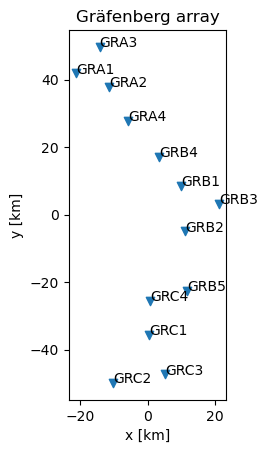

In [3]:
import matplotlib.pyplot as plt
import torch
from obspy.signal.util import util_geo_km

# pre-process seismograms for reasonable stable results
st = st_orig.copy()
st.detrend("demean")
st.detrend("linear")
st.filter("highpass", freq=0.01, zerophase=True)
st.taper(max_percentage=0.01, type="hann")

# force all traces to have same length
# 0s are not an issue for beamforming
st.merge(fill_value=0)
st.trim(t1, t2, pad=True, fill_value=0)

# prepare waveforms tensor
waveforms = torch.tensor([tr.data for tr in st])

# stations that data is present for
stations = [tr.stats.station for tr in st]

# extract locations in same order from inv
coordinates = []
station_order = []
for station in stations:
    for net in inv:
        for sta in net:
            if sta.code == station:
                coordinates.append((sta.longitude, sta.latitude))
                station_order.append(sta.code)
coordinates = torch.tensor(coordinates)

# convert coordinates to cartesian, relative to geographical array center
coordinates_cartesian = []
for sta in coordinates:
    coordinates_cartesian.append(
        util_geo_km(
            torch.mean(coordinates[:, 0]), torch.mean(coordinates[:, 1]), sta[0], sta[1]
        )
    )
coordinates_cartesian = torch.tensor(coordinates_cartesian)

fig, ax = plt.subplots()
ax.scatter(*coordinates_cartesian.T, marker="v")
ax.set_aspect("equal")
for i, txt in enumerate(station_order):
    ax.annotate(txt, (coordinates_cartesian[i, 0], coordinates_cartesian[i, 1]))
ax.set(title="Gräfenberg array", xlabel="x [km]", ylabel="y [km]")

## 2. Slowness space

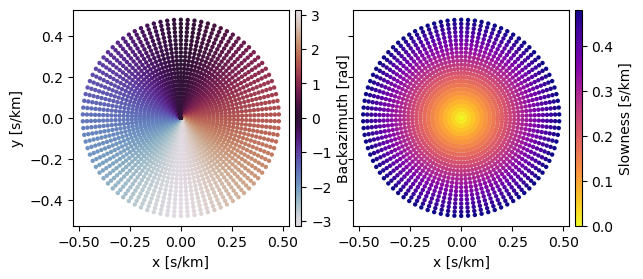

In [4]:
from itertools import product

# define slowness space to explore
# defined in backazimuth [º] and abs(slowness) [s/km]
backazimuth_spacing = 4
slowness_min = 0
slowness_max = 0.5
slowness_spacing = 0.02

azs = torch.arange(0, 2 * torch.pi, backazimuth_spacing * 2 * torch.pi / 360)
slows = torch.arange(slowness_min, slowness_max, slowness_spacing)
slowness_space = torch.tensor(
    [(torch.sin(az) * s, torch.cos(az) * s) for az, s in product(azs, slows)]
)

# visualise slowness space
fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.3)

# corresponding azs and slowns in slowness_space
azs_calc = torch.atan2(slowness_space[:, 0], slowness_space[:, 1])
slows_calc = torch.norm(slowness_space, dim=1)

ax = axs[0]
sct = ax.scatter(*slowness_space.T, c=azs_calc, s=10, lw=0, cmap="twilight")
ax.set(aspect="equal", xlabel="x [s/km]", ylabel="y [s/km]")
x0, y0, w, h = ax.get_position().bounds
cbar_ax = fig.add_axes([x0 + w + 0.01, y0, 0.01, h])
cbar = fig.colorbar(sct, cax=cbar_ax, label="Backazimuth [rad]")

ax = axs[1]
sct = ax.scatter(*slowness_space.T, c=slows_calc, s=10, lw=0, cmap="plasma_r")
ax.set(aspect="equal", yticklabels=[], xlabel="x [s/km]")
x0, y0, w, h = ax.get_position().bounds
cbar_ax = fig.add_axes([x0 + w + 0.01, y0, 0.01, h])
cbar = fig.colorbar(sct, cax=cbar_ax, label="Slowness [s/km]")

## 3. Beamforming

In [5]:
# Beamforming setup

# Primary microseism band
fmin = 0.05
fmax = 0.1

# Define time windows to beamform in
# allows for overlapping windows

times = torch.tensor(st[0].times())
window_length = 2 * 3600  # sec
window_limits = 0, times[-1] - window_length
window_overlap = 0.5

# prepare beamforming in time windows moving over signals
# and restricting data to frequency band of interest

# windows to beamform in
windows = torch.arange(
    window_limits[0],
    window_limits[1] - window_length,
    window_length * (1 - window_overlap),
)

print(f"{windows.shape=}")

# reference point for relative plane-wave traveltimes
# arbitrary but must be reasonably nearby
reference_point = torch.mean(coordinates_cartesian, axis=0)

# define start and end indices of each window
sampling_rate = st[0].stats.sampling_rate
starttime_idxs = (windows * sampling_rate).int()
endtime_idxs = starttime_idxs + int(window_length * sampling_rate)

print(f"{starttime_idxs.shape=}")

# compute expected frequencies, and limit to range of interest
f = torch.fft.fftfreq(int(window_length * sampling_rate), d=1 / sampling_rate)

omega = 2 * torch.pi * f
omega_limited = omega[torch.where((f > fmin) & (f < fmax))]
print(f"{omega_limited.shape=}")

# cut timewindows from correlations
waveforms_prep = torch.zeros(
    (len(windows), waveforms.shape[0], int(window_length * sampling_rate))
)

print(f"{waveforms_prep.shape=}")
for window_idx, (starttime_idx, endtime_idx) in enumerate(
    zip(starttime_idxs, endtime_idxs)
):
    waveforms_prep[window_idx] = waveforms[:, starttime_idx:endtime_idx]
# compute data spectra and limit to frequency band of interest
data_spectra_all = torch.fft.fft(waveforms_prep, dim=-1)

print(f"{data_spectra_all.shape=}")
data_spectra_all_limited = data_spectra_all[
    :, :, torch.where((f > fmin) & (f < fmax))[0]
]
print(f"{data_spectra_all_limited.shape=}")

windows.shape=torch.Size([92])
starttime_idxs.shape=torch.Size([92])
omega_limited.shape=torch.Size([359])
waveforms_prep.shape=torch.Size([92, 13, 7200])
data_spectra_all.shape=torch.Size([92, 13, 7200])
data_spectra_all_limited.shape=torch.Size([92, 13, 359])


In [6]:
# BEAMFORMING
traveltimes_space = torch.einsum(
    "nx, sx -> sn", reference_point - coordinates_cartesian, slowness_space
)

synth_spectra_space = torch.exp(
    -1j * torch.einsum("sn, w -> snw", traveltimes_space, omega_limited)
)

S = torch.einsum(
    "siw, sjw -> sijw", synth_spectra_space, torch.conj(synth_spectra_space)
)

# compute the cross-spectra between all stations for all time windows.
# notice the additional dimension for time windows t.
K = torch.einsum(
    "tiw, tjw -> tijw", data_spectra_all_limited, torch.conj(data_spectra_all_limited)
)

diag_idxs = torch.arange(K.shape[1])
zero_spectra = torch.zeros(omega_limited.shape, dtype=torch.cfloat)
K[:, diag_idxs, diag_idxs, :] = zero_spectra

beampowers_for_time = torch.einsum("sjiw, tijw -> ts", S, K).real
beampowers_for_time.shape

torch.Size([92, 2250])

## 4. Visualisation of results

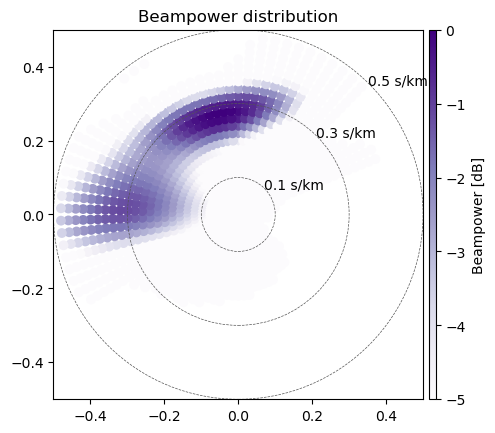

In [7]:
# plot full beampower distribution for the first time window for quality check
bp_to_plot = beampowers_for_time[0]

# replace all nans with 0s
bp_to_plot[torch.isnan(bp_to_plot)] = 0
# convert to dB (negative values become nan)
bp_to_plot = 10 * torch.log10(bp_to_plot / torch.max(bp_to_plot))

fig, ax = plt.subplots()
sct = ax.scatter(
    *slowness_space.T,
    c=bp_to_plot,
    s=50,
    lw=0,
    cmap="Purples",
    vmin=-5,
    vmax=0,
)

ax.set(
    xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), aspect="equal", title="Beampower distribution"
)

# mark some slownesses for orientation
for radius in [0.1, 0.3, 0.5]:
    circle = plt.Circle((0, 0), radius, color="#555", fill=False, ls="--", lw=0.5)
    ax.add_artist(circle)
    # add slowness labels
    ax.text(
        radius * 0.7,
        radius * 0.7,
        f"{radius:.1f} s/km",
    )

x0, y0, w, h = ax.get_position().bounds
cbar_ax = fig.add_axes([x0 + w + 0.01, y0, 0.01, h])
cbar = fig.colorbar(sct, cax=cbar_ax, label="Beampower [dB]")

/home/zmaw/u254070/anaconda3/envs/311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


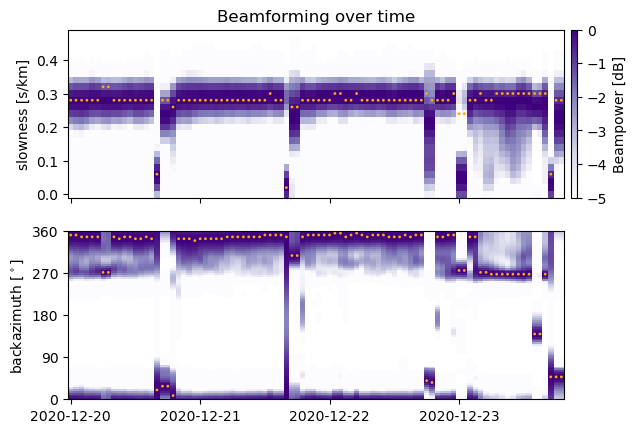

In [ ]:
# Visualise beamforming results over time
import matplotlib.dates as mdates

# pick best beampower for each time window
picked_maxima = torch.argmax(beampowers_for_time, axis=1)

# compute backazimuth and slowness for picked maxima
picked_azs = torch.rad2deg(
    torch.atan2(slowness_space[picked_maxima, 0], slowness_space[picked_maxima, 1])
)
# atan2 gives [-pi, pi], azs were defined [0, 2pi]
picked_azs[picked_azs < 0] += 360
picked_slows = torch.norm(slowness_space[picked_maxima], dim=1)

# also extract the corresponding backazimuth- and slowness-slices
# relative to best beampower, i.e., the picked maxima, for plotting.
# gives a better impression of how clean the beamforming result is in the final plots.

# find indices of picked slownesses and backazimuths
picked_slow_idxs = torch.argmin(torch.abs(slows - picked_slows[:, None]), axis=1)
picked_az_idxs = torch.argmin(torch.abs(torch.rad2deg(azs) - picked_azs[:, None]), axis=1)

# compute what slowness/backazimuth indices are found at which slowness_space indices
azs_idxs = torch.arange(0, len(azs), dtype=torch.int)
slow_idxs = torch.arange(0, len(slows), dtype=torch.int)
idx_space = torch.cartesian_prod(azs_idxs, slow_idxs)

# reshape to find slices based in slowness/backazimuth indices
bp_reshaped = beampowers_for_time.reshape(-1, len(azs), len(slows))

# select slices
bp_reshaped_slowness_slice = torch.stack(
    [bp_reshaped[idx, az_pick, :] for idx, az_pick in enumerate(picked_az_idxs)]
)

bp_reshaped_az_slice = torch.stack(
    [bp_reshaped[idx, :, slow_pick] for idx, slow_pick in enumerate(picked_slow_idxs)]
)

# normalise slices for plotting, individually per step in time
bp_reshaped_slowness_slice_dB = 10 * torch.log10(
    bp_reshaped_slowness_slice
    / bp_reshaped_slowness_slice.max(dim=1, keepdim=True).values
)

bp_reshaped_az_slice_dB = 10 * torch.log10(
    bp_reshaped_az_slice / bp_reshaped_az_slice.max(dim=1, keepdim=True).values
)

# compute correct time axis

times_plot = torch.tensor(
    [(t1 + t).matplotlib_date for t in windows.numpy()], dtype=torch.float32
)

fig, axs = plt.subplots(2, sharex=True)

axs[0].pcolormesh(
    *torch.meshgrid(
        times_plot,
        slows,
    ),
    bp_reshaped_slowness_slice_dB,
    cmap="Purples",
    vmin=-5,
    vmax=0,
    shading="auto",
)

axs[0].scatter(
    times_plot,
    picked_slows,
    ls="",
    marker="o",
    s=1,
    lw=0,
    c="#FFA90E",
)

axs[0].set(
    ylabel="slowness [s/km]",
    title="Beamforming over time",
)

pcm = axs[1].pcolormesh(
    *torch.meshgrid(
        times_plot,
        torch.rad2deg(azs),
    ),
    bp_reshaped_az_slice_dB,
    cmap="Purples",
    vmin=-5,
    vmax=0,
    shading="auto",
)

axs[1].scatter(
    times_plot,
    picked_azs,
    ls="",
    marker="o",
    s=1,
    lw=0,
    c="#FFA90E",
    label="backazimuth",
)
axs[1].set(
    ylim=[0, 360],
    yticks=[0, 90, 180, 270, 360],
    ylabel="backazimuth [$^\circ$]",
)

x0, y0, w, h = axs[0].get_position().bounds
cbar_ax = fig.add_axes([x0 + w + 0.01, y0, 0.01, h])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Beampower [dB]")

# format time axis
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))